In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from badass_music.theory.western.scales.chromatic import chromatic_scale_pitch_class_names

In [2]:
# VitD - 2B (backup track) - F# major
# VitD - 3A (regular) - Bb minor

# for reference:
# 2A = Eb minor
# 3B = Db major

In [3]:
track_to_analyze_filename = os.environ['BMPP_HOME'] + '/badass_music/data/Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix).mp3'
#track_to_analyze_filename = os.environ['BMPP_HOME'] + '/badass_music/data/Lady Napalm - Voice in the Distance.mp3'

sampling_rate_for_import = 11025 / 2  # 22050 #  48000

In [4]:
y, sr = librosa.load(
    track_to_analyze_filename,
    sr = sampling_rate_for_import,
)
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [5]:
dft_result_numpy = np.fft.fft(y_harmonic)

dft_result_numpy = np.fft.rfft(y_harmonic)  # "r"

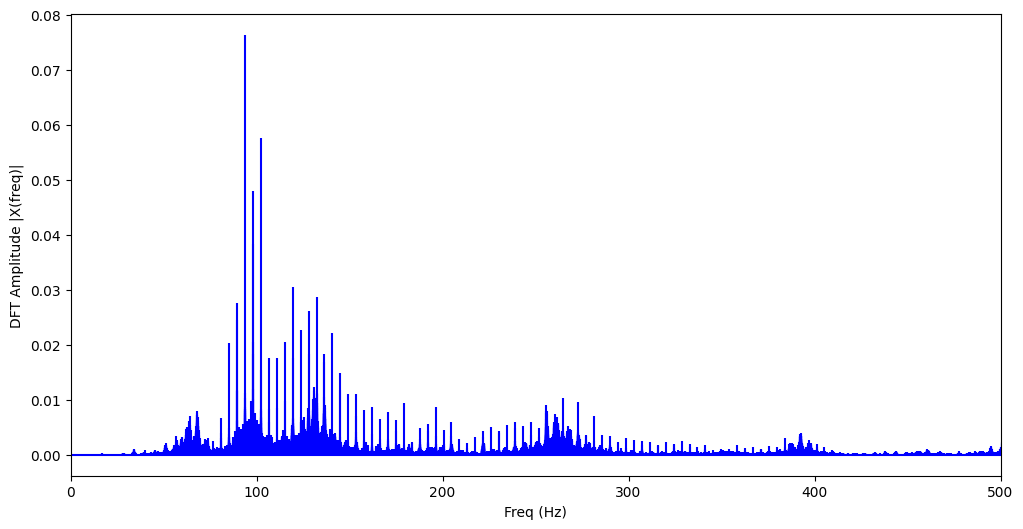

In [6]:
# https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html

X = dft_result_numpy
N = len(X)
n = np.arange(N)
T = N / sampling_rate_for_import
freq = n / T 

n_oneside = N // 2
f_oneside = freq[:n_oneside]
X_oneside = X[:n_oneside] / n_oneside

#plt.figure(figsize = (8, 6))
#plt.stem(freq, abs(X), 'b', markerfmt=" ", basefmt="-b")
#plt.xlabel('Freq (Hz)')
#plt.ylabel('DFT Amplitude |X(freq)|')
#plt.show()

plt.figure(figsize = (12, 6))
plt.stem(f_oneside, np.abs(X_oneside), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.xlim(0, 500)
plt.show()

In [7]:
index_max = np.argmax(X_oneside)
print(f_oneside[index_max])

89.59668242780441


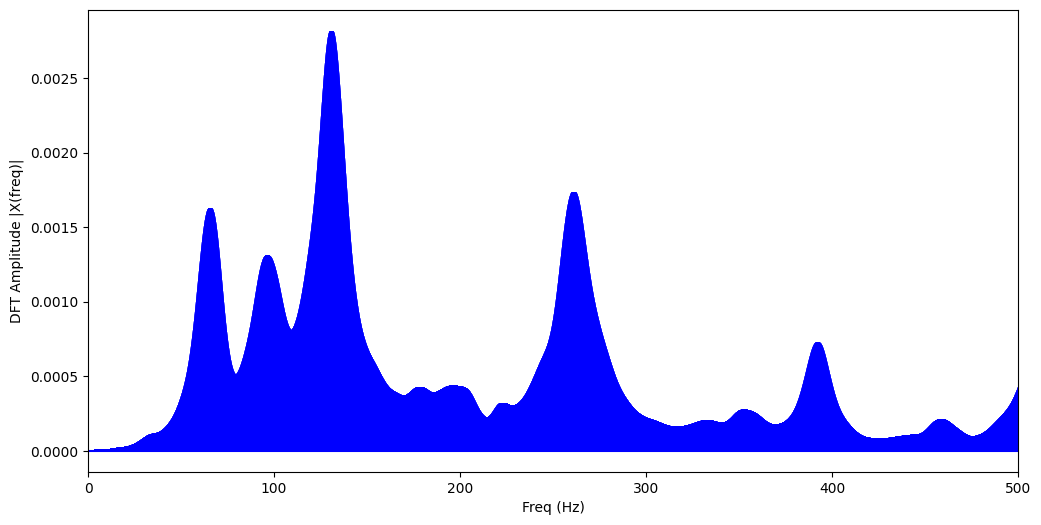

In [8]:
from scipy.ndimage import gaussian_filter1d

sigma = 500
X_oneside_abs_filtered = gaussian_filter1d(np.abs(X_oneside), sigma = sigma)

plt.figure(figsize = (12, 6))
plt.stem(f_oneside, X_oneside_abs_filtered, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.xlim(0, 500)
plt.show()

In [9]:
index_max_filtered = np.argmax(X_oneside_abs_filtered)
print(f_oneside[index_max_filtered])

130.96773569897698


In [10]:
indices_filtered = np.argsort(X_oneside_abs_filtered)
print(f_oneside[indices_filtered[-5:]])

[130.98126892 130.95420248 130.97450231 130.96096909 130.9677357 ]


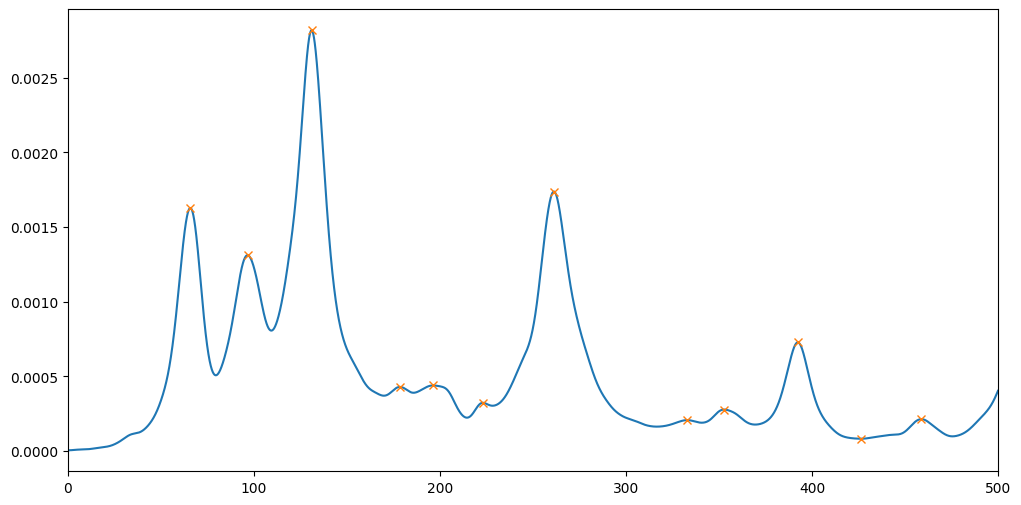

In [11]:
from scipy.signal import find_peaks
x = X_oneside_abs_filtered


#f_oneside = freq[:n_oneside]

peaks, _ = find_peaks(x, height=0)

plt.figure(figsize = (12, 6))
plt.plot(f_oneside, x)
plt.plot(f_oneside[peaks], x[peaks], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")

#print(f_oneside[peaks[0:10]])

#plt.xlabel('Freq (Hz)')
#plt.ylabel('DFT Amplitude |X(freq)|')
plt.xlim(0, 500)

plt.show()
plt.close()

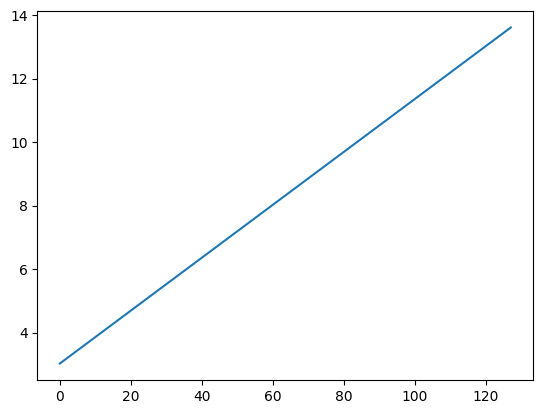

In [12]:
from badass_music.MIDI.MIDI_number_to import MIDI_note_number_array_to_frequency_array
from badass_music.MIDI.MIDI_number_to import MIDI_note_number_array_to_pitch_class_array
from badass_music.MIDI.MIDI_number_to import MIDI_note_number_array_to_scientific_pitch_octave_array

MIDI_note_numbers = np.arange(0, 128)
#MIDI_note_numbers

MIDI_note_frequencies = MIDI_note_number_array_to_frequency_array(MIDI_note_numbers)
#MIDI_note_frequencies

plt.figure()
plt.plot(MIDI_note_numbers, np.log2(MIDI_note_frequencies))
plt.show()
plt.close()

In [13]:
# this is left over from debugging
number_to_use = len(f_oneside)
f = f_oneside[peaks[0:number_to_use]]
x_n2u = x[peaks[0:number_to_use]]


# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]




In [14]:
results_list = []
for i in range(0, len(f)):
    q = find_nearest(np.log2(MIDI_note_frequencies), np.log2(f)[i])
    x_i = x_n2u[i]
    
    location = np.where(
        np.log2(MIDI_note_frequencies) == q
    )[0][0]

    results_list.append(
        {
            'frequency_rfft' : f[i],
            'frequency_nearest_MIDI' : MIDI_note_frequencies[location],
            'pitch' : chromatic_scale_pitch_class_names[
                MIDI_note_number_array_to_pitch_class_array(MIDI_note_numbers[location])
            ],
            'octave' : MIDI_note_number_array_to_scientific_pitch_octave_array(MIDI_note_numbers[location]),
            'amplitude' : x_i,
        }
    )

df = pd.DataFrame(results_list)
df.sort_values(by = ['amplitude'], ascending = False)

,frequency_rfft,frequency_nearest_MIDI,pitch,octave,amplitude
2,130.967736,130.812783,C,3,0.002818
6,261.238511,261.625565,C,4,0.001738
0,65.778215,65.406391,C,2,0.001628
12,523.546146,523.251131,C,5,0.001403
1,96.545991,97.998859,G,2,0.001312
...,...,...,...,...,...
91,2672.980098,2637.020455,E,7,0.000029
92,2688.347069,2637.020455,E,7,0.000024
93,2700.838231,2637.020455,E,7,0.000021
94,2700.878831,2637.020455,E,7,0.000021


In [15]:
df.groupby(['pitch'])[['amplitude']].agg('sum').sort_values(by = ['amplitude'], ascending = False)

,amplitude
pitch,
C,0.008505
G,0.003514
F,0.002078
E,0.001022
Bb,0.001010
D,0.000871
A,0.000828
Eb,0.000808
Db,0.000686


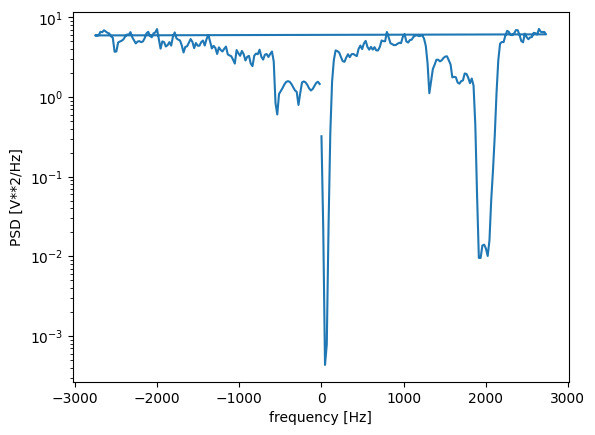

In [16]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html

from scipy.signal import welch

welch_nperseg = 256 # 1024
fs = sampling_rate_for_import

f, Pxx_den = welch(X, fs, nperseg = welch_nperseg, return_onesided = False)
                          
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()



In [23]:
Pxx_den_sorted_indices = np.argsort(Pxx_den)
i = np.arange(len(Pxx_den) - 1, len(Pxx_den) - 1 - 3, -1)
indices = Pxx_den_sorted_indices[i]

f[indices]

array([ 2648.58398438, -2002.58789062,  2368.65234375])